In [ ]:
# Note jupyter notebook cant seem to open the viewing window

In [35]:
#Libraries
from pyueye import ueye
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt

In [36]:
#Variables
hCam = ueye.HIDS(0)             #0: first available camera;  1-254: The camera with the specified camera ID
sInfo = ueye.SENSORINFO()
cInfo = ueye.CAMINFO()
pcImageMemory = ueye.c_mem_p()
MemID = ueye.int()
rectAOI = ueye.IS_RECT()
pitch = ueye.INT()
nBitsPerPixel = ueye.INT(8)    #24: bits per pixel for color mode; take 8 bits per pixel for monochrome
channels = 1                    #3: channels for color mode(RGB); take 1 channel for monochrome
m_nColorMode = ueye.INT()		# Y8/RGB16/RGB24/REG32
bytes_per_pixel = int(nBitsPerPixel / 8)
#---------------------------------------------------------------------------------------------------------------------------------------
print("START")
print()


START



In [37]:
# Starts the driver and establishes the connection to the camera
nRet = ueye.is_InitCamera(hCam, None)
if nRet != ueye.IS_SUCCESS:
    print("is_InitCamera ERROR")

# Reads out the data hard-coded in the non-volatile camera memory and writes it to the data structure that cInfo points to
nRet = ueye.is_GetCameraInfo(hCam, cInfo)
if nRet != ueye.IS_SUCCESS:
    print("is_GetCameraInfo ERROR")

# You can query additional information about the sensor type used in the camera
nRet = ueye.is_GetSensorInfo(hCam, sInfo)
if nRet != ueye.IS_SUCCESS:
    print("is_GetSensorInfo ERROR")

nRet = ueye.is_ResetToDefault( hCam)
if nRet != ueye.IS_SUCCESS:
    print("is_ResetToDefault ERROR")

In [38]:
if int.from_bytes(sInfo.nColorMode.value, byteorder='big') == ueye.IS_COLORMODE_MONOCHROME:
    # for color camera models use RGB32 mode
    m_nColorMode = ueye.IS_CM_MONO8
    nBitsPerPixel = ueye.INT(8)
    bytes_per_pixel = int(nBitsPerPixel / 8)
    print("IS_COLORMODE_MONOCHROME: ", )
    print("\tm_nColorMode: \t\t", m_nColorMode)
    print("\tnBitsPerPixel: \t\t", nBitsPerPixel)
    print("\tbytes_per_pixel: \t\t", bytes_per_pixel)
    print()

IS_COLORMODE_MONOCHROME: 
	m_nColorMode: 		 6
	nBitsPerPixel: 		 8
	bytes_per_pixel: 		 1



In [39]:
# Can be used to set the size and position of an "area of interest"(AOI) within an image
nRet = ueye.is_AOI(hCam, ueye.IS_AOI_IMAGE_GET_AOI, rectAOI, ueye.sizeof(rectAOI))
if nRet != ueye.IS_SUCCESS:
    print("is_AOI ERROR")
width = rectAOI.s32Width
height = rectAOI.s32Height

In [40]:
# Prints out some information about the camera and the sensor
print("Camera model:\t\t", sInfo.strSensorName.decode('utf-8'))
print("Camera serial no.:\t", cInfo.SerNo.decode('utf-8'))
print("Maximum image width:\t", width)
print("Maximum image height:\t", height)
print()

Camera model:		 UI149xLE-M
Camera serial no.:	 4103218478
Maximum image width:	 3840
Maximum image height:	 2748



In [28]:
exposure_time = 0.00001
exposure_time_ue = ueye.double(exposure_time)
nRet = ueye.is_Exposure(hCam, ueye.IS_EXPOSURE_CMD_GET_EXPOSURE, exposure_time_ue, ueye.sizeof(exposure_time_ue))

In [8]:

# Allocates an image memory for an image having its dimensions defined by width and height and its color depth defined by nBitsPerPixel
nRet = ueye.is_AllocImageMem(hCam, width, height, nBitsPerPixel, pcImageMemory, MemID)
if nRet != ueye.IS_SUCCESS:
    print("is_AllocImageMem ERROR")
else:
    # Makes the specified image memory the active memory
    nRet = ueye.is_SetImageMem(hCam, pcImageMemory, MemID)
    if nRet != ueye.IS_SUCCESS:
        print("is_SetImageMem ERROR")
    else:
        # Set the desired color mode
        nRet = ueye.is_SetColorMode(hCam, m_nColorMode)


In [9]:
# Activates the camera's live video mode (free run mode)
nRet = ueye.is_CaptureVideo(hCam, ueye.IS_DONT_WAIT)
if nRet != ueye.IS_SUCCESS:
    print("is_CaptureVideo ERROR")

In [30]:
nRet = ueye.is_SetFrameRate(hCam, 1000, ueye.double(100))
if nRet != ueye.IS_SUCCESS:
    print("is_SetFrameRate ERROR")


In [31]:
# Enables the queue mode for existing image memory sequences
nRet = ueye.is_InquireImageMem(hCam, pcImageMemory, MemID, width, height, nBitsPerPixel, pitch)
if nRet != ueye.IS_SUCCESS:
    print("is_InquireImageMem ERROR")
else:
    print("Press q to leave the programm")

Press q to leave the programm


In [32]:
import numpy as np

[255 255 255 ... 255 255 255]


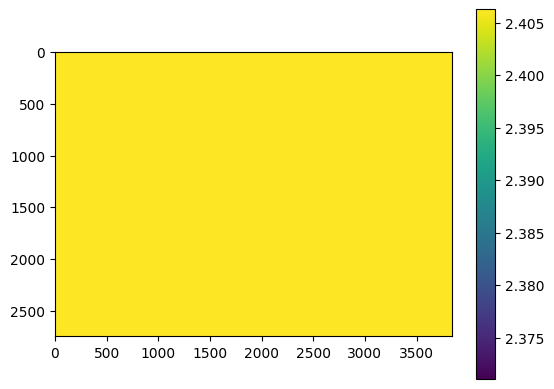

In [33]:
array = ueye.get_data(pcImageMemory, width, height, nBitsPerPixel, pitch, copy=False)

print(array)
frame = np.reshape(array,(height.value, width.value, bytes_per_pixel))
plt.imshow(np.log10(np.abs(frame)))
plt.colorbar()

In [15]:
# Continuous image display
while(nRet == ueye.IS_SUCCESS):

    # In order to display the image in an OpenCV window we need to...
    # ...extract the data of our image memory
    array = ueye.get_data(pcImageMemory, width, height, nBitsPerPixel, pitch, copy=False)

    # bytes_per_pixel = int(nBitsPerPixel / 8)

    # ...reshape it in an numpy array...
    frame = np.reshape(array,(height.value, width.value, bytes_per_pixel))

    # ...resize the image by a half
    frame = cv2.resize(frame,(0,0),fx=0.5, fy=0.5)

KeyboardInterrupt: 

In [41]:
# Releases an image memory that was allocated using is_AllocImageMem() and removes it from the driver management
ueye.is_FreeImageMem(hCam, pcImageMemory, MemID)

# Disables the hCam camera handle and releases the data structures and memory areas taken up by the uEye camera
ueye.is_ExitCamera(hCam)

# Destroys the OpenCv windows
cv2.destroyAllWindows()